In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import neural
import copy
import functions
import pickle
import os

# Test data loading from simulations

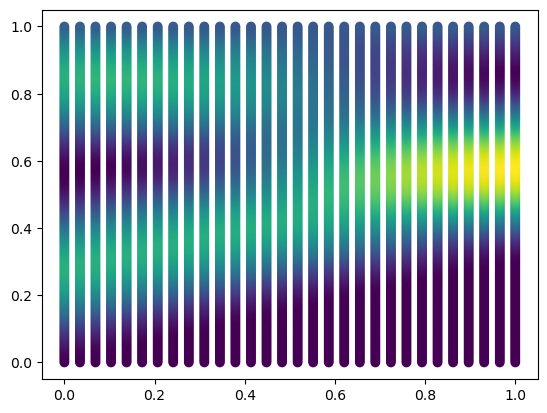

In [11]:
# a, b = functions.sample_simulation_data("data/case_a.npy", np.linspace(0, 1, 30), np.linspace(0, 1, 200), mode="voltage")

data = functions.TransmissionLineSimulation.load("data/case_a.pt")

a, b = data.sample(np.linspace(0, 1, 30), np.linspace(0, 1, 200), mode="voltage")

fig, ax = plt.subplots()

ax.scatter(
    a[0, :],
    a[1, :],
    c=b
)

# Training the base NN

## Configuration

In [7]:
simulator_data_file = "data/case_a.pt"

voltage_current_relation_parameters = { "loss_function_parameters": { "RL": 5 }, "n_points": 200 }
ic_parameters = {"loss_function_parameters": {}, "n_x_points": 200 }

voltage_measurement_parameters = {
    "loss_function_parameters": { },
    "filename": simulator_data_file,
    "x_points": [0, 1],
    "n_t_points": 200
}

current_measurement_parameters = {
    "loss_function_parameters": { },
    "filename": simulator_data_file,
    "x_points": [0, 1],
    "n_t_points": 200
}


physics_parameters = {
    "loss_function_parameters": {
        "gamma": 0, #10**-3,
        "L": 3.0/10,
        "C": 3.0/10,
        "R": 0.01,
        "G": 1/10**5        
    },
    "adaptive_weighting": None,
        # {
        #     "reweighting_period": 1000,
        #     "epsilon_initial": 0.01,
        #     "epsilon_final": 100
        # },
    "n_points": 15000,
    "resample_period": 5000,
}

trainer_parameters = {
    "n_epochs": 10000,
    "loss_weights": {
        "ic": 1.0,
        "sim_data": 1.0,
        # "bc_left": 1.0,
        # "bc_right": 1.0,
        "physics": 2.0
    },
    "linear_weights": None,
        # {
        # "initial": {
        #     "ic": 1.0,
        #     # "sim_data": 1.0,
        #     "bc_left": 1.0,
        #     "bc_right": 1.0,
        #     "physics": 1.0
        # },
        # "final": {
        #     "ic": 1.0,
        #     # "sim_data": 1.0,
        #     "bc_left": 1.0,
        #     "bc_right": 1.0,
        #     "physics": 1.0
        # }
    "adaptive_loss_weights": False,
    "bfgs": True
}   


# bc_left_loss_block = neural.LossBlock("voltage_loss_function", "bc_left_setup", bc_left_parameters)
# bc_right_loss_block = neural.LossBlock("voltage_and_current_relation_loss_function", "bc_right_setup", bc_right_parameters)
# bc_from_simulation = neural.LossBlock("voltage_and_current_loss_function", "bc_from_simulation_setup", bc_from_simulation_parameters)
# bc_right_imposed_loss_block = neural.LossBlock("voltage_loss_function", "bc_right_imposed_setup", bc_right_imposed_parameters)


voltage_measurements_block = neural.LossBlock("voltage_measurement_loss_function", "voltage_measurement_setup", voltage_measurement_parameters)
current_measurements_block = neural.LossBlock("current_measurement_loss_function", "current_measurement_setup", current_measurement_parameters)

ic_loss_block = neural.LossBlock("full_zero_loss_function", "ic_setup", ic_parameters)
physics_loss_block = neural.LossBlock("physics_loss_function", "physics_setup", physics_parameters)
voltage_current_relation_loss_block = neural.LossBlock("voltage_current_loss_function", "voltage_current_setup", voltage_current_relation_parameters)



model_config = neural.ModelConfig(
    [2, 10, 10, 10, 10, 2],
    # [2, 10, 10, 10, 10, 10, 2],
    "torch.tanh"
)

base_trainer_config = neural.TrainerConfig(
    optimizer_config=neural.OptimizerConfig("torch.optim.Adam", lr=0.001),
    lr_scheduler_config=None,
    update_function="update_training",
    parameters=trainer_parameters,
)

# # Training with scheduler
# scheduled_trainer_config = neural.TrainerConfig(
#     optimizer_config=neural.OptimizerConfig("torch.optim.Adam", lr=0.005),
#     lr_scheduler_config=neural.LrSchedulerConfig("torch.optim.lr_scheduler.LinearLR", start_factor=1, end_factor=0.1, total_iters=30000),
#     update_function="update_training",
#     parameters=trainer_parameters,
# )

loss_blocks = {
    # "bc_left": bc_left_loss_block,
    # "bc_right": bc_right_loss_block,
    "ic": ic_loss_block,
    "physics": physics_loss_block,
    "voltage_measurements": voltage_measurements_block,
    "current_measurements": current_measurements_block,
    # "bc_right_imposed": bc_right_imposed_loss_block
}

function_dictionary = {
    "torch.optim.Adam": torch.optim.Adam,
    "torch.optim.lr_scheduler.LinearLR": torch.optim.lr_scheduler.LinearLR,
    "torch.tanh": torch.tanh,


    "full_zero_loss_function": functions.full_zero_loss_function,
    "voltage_measurement_loss_function": functions.voltage_measurement_loss_function,
    "current_measurement_loss_function": functions.current_measurement_loss_function,

    "voltage_current_relation_loss_function": functions.voltage_current_relation_loss_function,
    "physics_loss_function": functions.physics_loss_function,


    "ic_setup": functions.ic_setup,
    "voltage_measurement_setup": functions.voltage_measurement_setup,
    "current_measurement_setup": functions.current_measurement_setup,

    "voltage_current_relation_setup": functions.voltage_current_relation_setup,
    "physics_setup": functions.physics_setup,


    "update_training": functions.update_training,
}

# Use seed
complete_config = neural.CompleteConfig(model_config, base_trainer_config, loss_blocks, function_dictionary)

complete_config.save_json("the_config.json")

## Training

In [8]:
all_models = []
all_stats = []

loaded_config = neural.CompleteConfig.load_json("the_config.json", function_dictionary)

for i in range(3):
    final_model, stats, processed_config = loaded_config.train_model()
    all_models.append(final_model)
    all_stats.append(stats)

tensor(1.2896, grad_fn=<AddBackward0>)
tensor(0.0025, grad_fn=<AddBackward0>)
tensor(1.2928, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [5]:
loaded_config.model_config.activation_function
old_conf = neural.CompleteConfig.load_json("the_config.json", function_dictionary)
old_conf.model_config.activation_function

'torch.tanh'

## Check

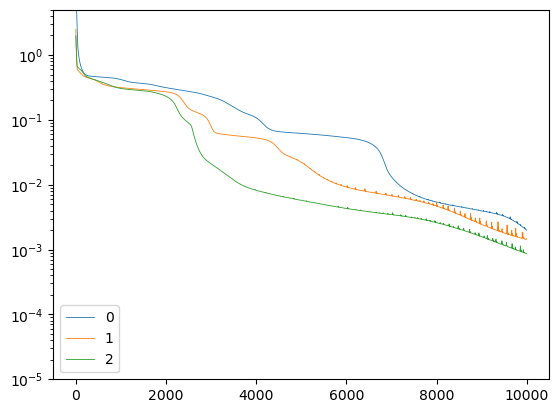

In [6]:
fig = plt.figure()
ax = fig.subplots()
for stat in all_stats:
    total_loss = stat.total_loss_array
    n_points = len(stat.total_loss_array)
    ax.semilogy(
        np.arange(n_points),
        total_loss,
        linewidth=0.6
    )
    ax.set_ylim(10**-5, 5*10**-0)

ax.legend(list(range(len(all_stats))), loc="lower left")

/home/alejpr/anaconda3/envs/torch/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1695391895886/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


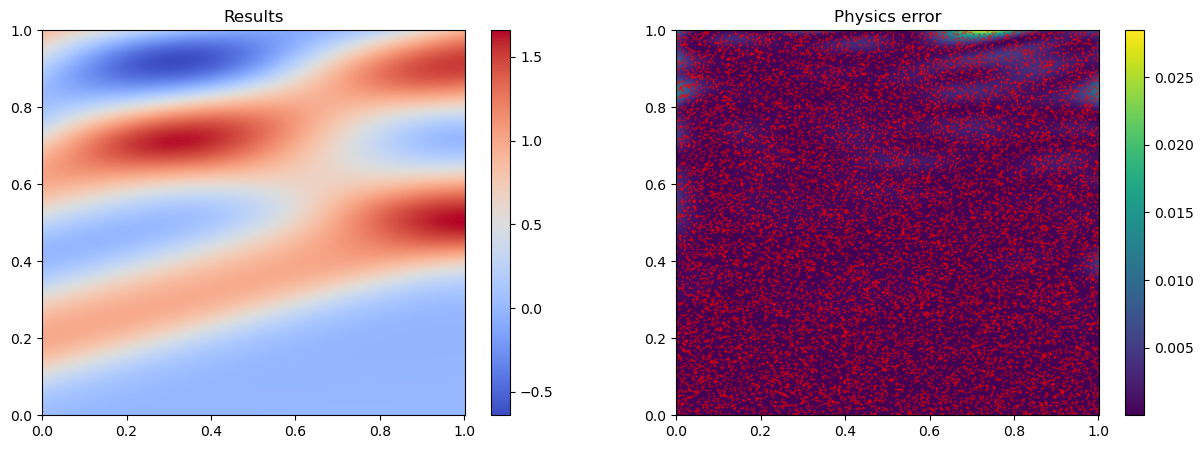

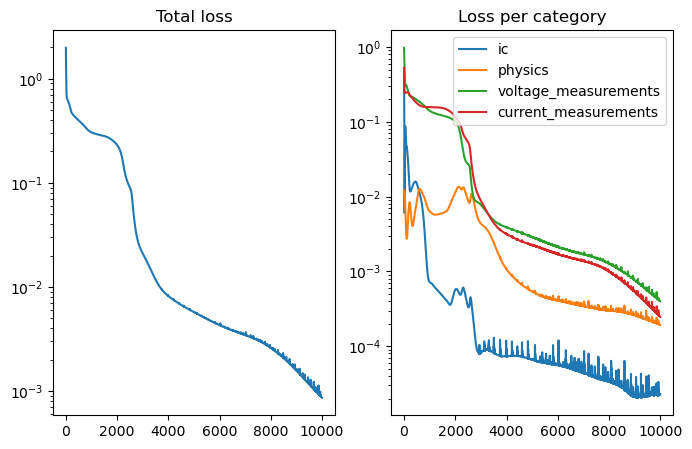

In [7]:

def show_model_results(final_model, stats):

    x_test = torch.linspace(0, 1, 1000)
    t_test = torch.linspace(0, 1, 1000)

    X, Y = torch.meshgrid(x_test, t_test)
    in_test = torch.stack((X.reshape(-1), Y.reshape(-1)), 0)

    with torch.no_grad():
        out = final_model(in_test)

    fig = plt.figure(figsize=(15, 5))
    axes = fig.subplots(1, 2)

    img = axes[0].pcolormesh(
        X, Y, out[0,:].reshape(1000, 1000),
        cmap="coolwarm",
        # vmin=-2.5,
        # vmax=2.5
        )
    # axes[0].scatter(residual_points[0,:].detach().numpy(), residual_points[1,:].detach().numpy(), s=1, c="g")
    fig.colorbar(img)

    train_points = processed_config.loss_blocks["physics"].x.detach().numpy()


    in_test.requires_grad_(True)
    phys_error = functions.physics_loss_function(final_model, in_test, None, physics_parameters["loss_function_parameters"])

    img = axes[1].pcolormesh(X, Y, phys_error.reshape(1000, 1000).detach().numpy())
    fig.colorbar(img)
    axes[1].scatter(train_points[0, :], train_points[1, :], s=0.1, c="r")

    axes[0].set_title("Results")
    axes[1].set_title("Physics error")


    fig = plt.figure(figsize=(8, 5))
    axes = fig.subplots(1, 2)
    epochs = np.arange(complete_config.trainer_config.parameters["n_epochs"])
    axes[0].semilogy(epochs, stats.total_loss_array)

    labels = []
    for name, loss in stats.loss_per_block.items():
        axes[1].semilogy(epochs, loss)
        labels.append(name)
        
    axes[1].legend(labels)

    axes[0].set_title("Total loss")
    axes[1].set_title("Loss per category")



final_model = all_models[0]
show_model_results(final_model, stats)

# a = torch.load("data/model_0.pt")
# final_model = neural.NN([2, 5, 5, 5, 5, 2])
# final_model.load_state_dict(state_dict=a)


## Save

In [3]:
import os
state_dict = all_models[1].state_dict()
torch.save(state_dict, os.path.join("data", "base_model.pt"))

NameError: name 'all_models' is not defined

# Training the G configurable model

## Initialize

In [45]:
# Make sure the layers are the same as for the base model
base_config: neural.CompleteConfig = neural.CompleteConfig.load_json("the_config.json", {})
layers = base_config.model_config.layers
print(layers)
    
g_model = neural.NNWithG(layers, [1, 10, 10, 1])

[2, 10, 10, 10, 10, 2]


## Train the value of G

tensor(0.0325, grad_fn=<MeanBackward0>)
tensor(1.4777e-08, grad_fn=<MeanBackward0>)
tensor(6.8931e-09, grad_fn=<MeanBackward0>)
tensor(2.6965e-09, grad_fn=<MeanBackward0>)
tensor(1.6908e-09, grad_fn=<MeanBackward0>)


''

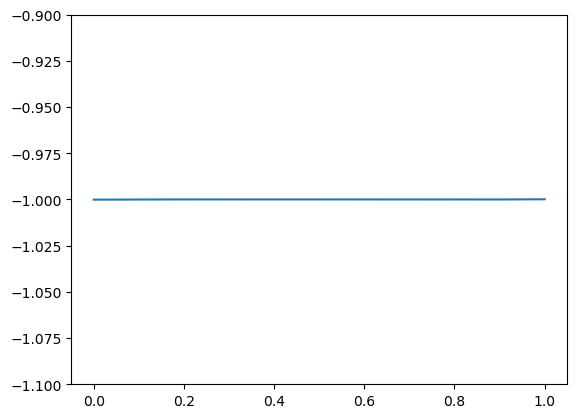

In [46]:
optimizer = torch.optim.Adam(g_model.parameters())
x_array = torch.linspace(0, 1, 300).reshape(1, -1)

for epoch in range(5000):
    optimizer.zero_grad()
    loss = torch.mean(torch.square(g_model.compute_g(x_array) + 1))
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(loss)
        
with torch.no_grad():
    y_test = g_model.compute_g(x_array).detach()

fig, ax = plt.subplots()
ax.plot(
    x_array.reshape(-1),
    y_test.reshape(-1)
)

ax.set_ylim(-1.1, -0.9)
""

## Load the weights from the base model

In [47]:
base_model_weights = torch.load(os.path.join("data", "base_model.pt"))

output = g_model.load_state_dict(base_model_weights, strict=False)

print(output)

_IncompatibleKeys(missing_keys=['Ws_G.0', 'Ws_G.1', 'Ws_G.2', 'bs_G.0', 'bs_G.1', 'bs_G.2'], unexpected_keys=[])


## Training Configuration

In [65]:
g_regularizer_parameters = {
    "loss_function_parameters": { "gamma": 0.001 }, # 0.00000001 },
    "reference_log_g": -1,
    "n_points": 200
}

simulator_data_file = "data/case_b.pt"

voltage_current_relation_parameters = { "loss_function_parameters": { "RL": 5 }, "n_points": 200 }
ic_parameters = {"loss_function_parameters": {}, "n_x_points": 200 }

voltage_measurement_parameters = {
    "loss_function_parameters": { },
    "filename": simulator_data_file,
    "x_points": [0, 0.25, 0.5, 0.75, 1],
    "n_t_points": 200
}

current_measurement_parameters = {
    "loss_function_parameters": { },
    "filename": simulator_data_file,
    "x_points": [0, 0.25, 0.5, 0.75, 1],
    "n_t_points": 200
}


physics_parameters = {
    "loss_function_parameters": {
        "gamma": 0, #10**-3,
        "L": 3.0/10,
        "C": 3.0/10,
        "R": 0.01,
        "G": 1/10        
    },
    "adaptive_weighting": None,
        # {
        #     "reweighting_period": 1000,
        #     "epsilon_initial": 0.01,
        #     "epsilon_final": 100
        # },
    "n_points": 15000,
    "resample_period": 5000,
}

trainer_parameters = {
    "n_epochs": 20000,
    "loss_weights": {
        "ic": 1.0,
        "sim_data": 1.0,
        "g_regularizer": 1.0,
        # "bc_left": 1.0,
        # "bc_right": 1.0,
        "physics": 2.0
    },
    "linear_weights": None,
        # {
        # "initial": {
        #     "ic": 1.0,
        #     # "sim_data": 1.0,
        #     "bc_left": 1.0,
        #     "bc_right": 1.0,
        #     "physics": 1.0
        # },
        # "final": {
        #     "ic": 1.0,
        #     # "sim_data": 1.0,
        #     "bc_left": 1.0,
        #     "bc_right": 1.0,
        #     "physics": 1.0
        # }
    "adaptive_loss_weights": False,
    "bfgs": True
}   


# bc_left_loss_block = neural.LossBlock("voltage_loss_function", "bc_left_setup", bc_left_parameters)
# bc_right_loss_block = neural.LossBlock("voltage_and_current_relation_loss_function", "bc_right_setup", bc_right_parameters)
# bc_from_simulation = neural.LossBlock("voltage_and_current_loss_function", "bc_from_simulation_setup", bc_from_simulation_parameters)
# bc_right_imposed_loss_block = neural.LossBlock("voltage_loss_function", "bc_right_imposed_setup", bc_right_imposed_parameters)


voltage_measurements_block = neural.LossBlock("voltage_measurement_loss_function", "voltage_measurement_setup", voltage_measurement_parameters)
current_measurements_block = neural.LossBlock("current_measurement_loss_function", "current_measurement_setup", current_measurement_parameters)

ic_loss_block = neural.LossBlock("full_zero_loss_function", "ic_setup", ic_parameters)
physics_g_inference_loss_block = neural.LossBlock("physics_g_inference_loss_function", "physics_setup", physics_parameters)
voltage_current_relation_loss_block = neural.LossBlock("voltage_current_loss_function", "voltage_current_setup", voltage_current_relation_parameters)

g_regularizer_block = neural.LossBlock("g_regularizer_loss_function", "g_regularizer_setup", g_regularizer_parameters)



model_config = neural.ModelConfig(
    [2, 10, 10, 10, 10, 2],
    # [2, 10, 10, 10, 10, 10, 2],
    "torch.tanh"
)

base_trainer_config = neural.TrainerConfig(
    optimizer_config=neural.OptimizerConfig("torch.optim.Adam", lr=0.001),
    lr_scheduler_config=None,
    update_function="update_training",
    parameters=trainer_parameters,
)

# # Training with scheduler
# scheduled_trainer_config = neural.TrainerConfig(
#     optimizer_config=neural.OptimizerConfig("torch.optim.Adam", lr=0.005),
#     lr_scheduler_config=neural.LrSchedulerConfig("torch.optim.lr_scheduler.LinearLR", start_factor=1, end_factor=0.1, total_iters=30000),
#     update_function="update_training",
#     parameters=trainer_parameters,
# )

loss_blocks = {
    # "bc_left": bc_left_loss_block,
    # "bc_right": bc_right_loss_block,
    "ic": ic_loss_block,
    "physics_g_inference": physics_g_inference_loss_block,
    "voltage_measurements": voltage_measurements_block,
    "current_measurements": current_measurements_block,
    "g_regularizer": g_regularizer_block,
    # "bc_right_imposed": bc_right_imposed_loss_block
}

function_dictionary = {
    "torch.optim.Adam": torch.optim.Adam,
    "torch.optim.lr_scheduler.LinearLR": torch.optim.lr_scheduler.LinearLR,
    "torch.tanh": torch.tanh,


    "full_zero_loss_function": functions.full_zero_loss_function,
    "voltage_measurement_loss_function": functions.voltage_measurement_loss_function,
    "current_measurement_loss_function": functions.current_measurement_loss_function,

    "voltage_current_relation_loss_function": functions.voltage_current_relation_loss_function,
    "physics_g_inference_loss_function": functions.physics_g_inference_loss_function,

    "g_regularizer_loss_function": functions.g_regularizer_loss_function,


    "ic_setup": functions.ic_setup,
    "voltage_measurement_setup": functions.voltage_measurement_setup,
    "current_measurement_setup": functions.current_measurement_setup,

    "voltage_current_relation_setup": functions.voltage_current_relation_setup,
    "physics_setup": functions.physics_setup,
    "g_regularizer_setup": functions.g_regularizer_setup,


    "update_training": functions.update_training,
}

# Use seed
complete_config = neural.CompleteConfig(model_config, base_trainer_config, loss_blocks, function_dictionary)

complete_config.save_json("retrain_config.json")

## Train

In [66]:
complete_config: neural.CompleteConfig = neural.CompleteConfig.load_json("retrain_config.json", function_dictionary)

g_train_model = copy.deepcopy(g_model)

final_g_model, stats, changed_config = complete_config.train_model(override_model=g_train_model)

tensor(0.3642, grad_fn=<AddBackward0>)
tensor(0.0010, grad_fn=<AddBackward0>)
tensor(0.0009, grad_fn=<AddBackward0>)
tensor(0.0008, grad_fn=<AddBackward0>)


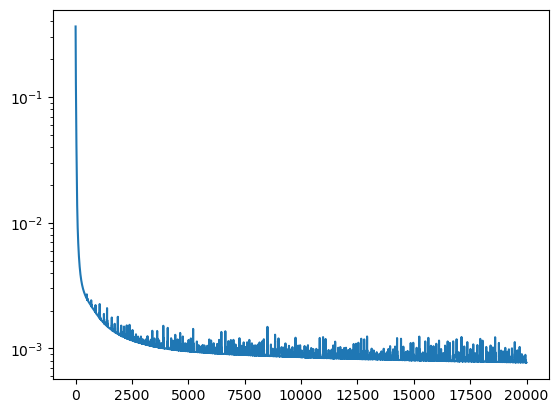

In [67]:
fig, ax = plt.subplots()
ax.semilogy(stats.total_loss_array)

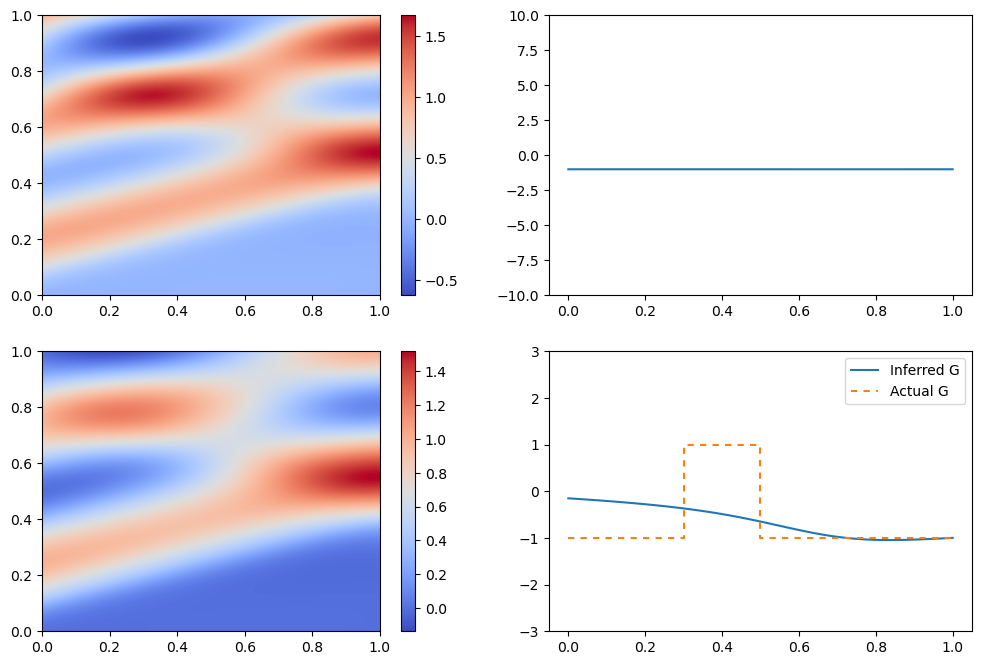

In [68]:
def show_model(base_model, retrained_model):
    x_array = torch.linspace(0, 1, 100).reshape(1, -1)
    base_log_g_array = base_model.compute_g(x_array).detach()
    retrained_log_g_array = retrained_model.compute_g(x_array).detach()

    x_test = torch.linspace(0, 1, 1000)
    t_test = torch.linspace(0, 1, 1000)

    X, Y = torch.meshgrid(x_test, t_test)
    in_test = torch.stack((X.reshape(-1), Y.reshape(-1)), 0)

    with torch.no_grad():
        base_out = base_model(in_test)
        retrained_out = retrained_model(in_test)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    img = axes[0, 0].pcolormesh(
        X, Y, base_out[0,:].reshape(1000, 1000),
        cmap="coolwarm",
        # vmin=-2.5,
        # vmax=2.5
        )
    fig.colorbar(img)

    img = axes[1, 0].pcolormesh(
        X, Y, retrained_out[0,:].reshape(1000, 1000),
        cmap="coolwarm",
        # vmin=-2.5,
        # vmax=2.5
        )
    fig.colorbar(img)


    axes[0, 1].plot(
        x_array.reshape(-1),
        base_log_g_array.reshape(-1)
    )
    axes[0, 1].set_ylim(-10, 10)

    h_1 = axes[1, 1].plot(
        x_array.reshape(-1),
        retrained_log_g_array.reshape(-1)
    )[0]
    h_2 = axes[1, 1].plot(
        [0, 0.3, 0.3, 0.5, 0.5, 1],
        [-1, -1, 1, 1, -1, -1],
        dashes=(3, 3)
    )[0]

    axes[1, 1].set_ylim(-3, 3)
    axes[1, 1].legend([h_1, h_2], ["Inferred G", "Actual G"])

show_model(g_model, final_g_model)

In [28]:
print(g_model.state_dict())
print(final_g_model.state_dict())

OrderedDict([('Ws.0', tensor([[-0.5040,  1.2668],
        [ 0.0304,  1.1640],
        [-0.3147, -0.7104],
        [ 0.5684,  1.1581],
        [-0.5731,  0.1061],
        [ 0.3667, -0.8547],
        [ 0.6317, -1.8221],
        [-0.5581, -0.8348],
        [-0.2565,  1.0849],
        [ 0.2959, -1.4328]])), ('Ws.1', tensor([[ 1.2568,  0.0661, -0.0280,  0.5000,  0.2939, -0.0294, -0.0675,  0.0451,
          1.2049, -0.5724],
        [-0.0060,  0.5977,  0.1451, -0.1126, -0.3407, -0.4618, -0.1736, -0.1244,
          0.3332,  0.0595],
        [ 1.0673,  0.5642,  0.4468, -0.1154,  0.3359,  0.0175, -0.3452, -0.2200,
          1.2120,  0.2875],
        [ 0.2663, -0.4095,  2.2255, -2.8722, -0.4767,  0.2410,  0.5663, -0.1290,
          0.0392,  0.4879],
        [ 1.7904, -0.7057, -0.4610,  0.4147,  0.1373, -0.6698, -0.6944,  0.0164,
          0.1576, -0.4455],
        [ 0.1294, -0.1818, -0.6229,  0.0696, -0.7891,  0.4556,  0.1091,  0.0137,
         -0.1718,  0.0260],
        [ 1.5035,  0.7283,  0.05

# Random Stuff

In [ ]:
a = np.load("data/case_a.npy", allow_pickle=True).item()

# print(a["t"])
t_test = torch.linspace(0, 10, 200)

with torch.no_grad():
    sender_output = final_model(
        torch.stack((torch.zeros(200), t_test ), 0)
    )
    receiver_output = final_model(
        torch.stack((torch.ones(200), t_test), 0)
    )

fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(t_test, sender_output[0, :])
axes[1, 0].plot(t_test, sender_output[1, :])

axes[0, 1].plot(t_test, receiver_output[0, :])
axes[1, 1].plot(t_test, receiver_output[1, :])


axes[0, 0].plot(a["t"], a["v_sender"], dashes=(4, 4))
axes[1, 0].plot(a["t"], a["i_sender"], dashes=(4, 4))

axes[0, 1].plot(a["t"], a["v_receiver"], dashes=(4, 4))
axes[1, 1].plot(a["t"], a["i_receiver"], dashes=(4, 4))

for i in range(2):
    for j in range(2):
        axes[i, j].set_ylim([-2.1, 2.1])


In [ ]:
import time
start = time.time_ns()
np.linalg.inv(np.random.uniform(-5, 5, (3900, 3900)))
print((time.time_ns() - start)/10**9)

In [ ]:
print(torch.max(processed_config.loss_blocks["physics"].w))
print(torch.min(processed_config.loss_blocks["physics"].w))
print(processed_config.loss_blocks["physics"].w)

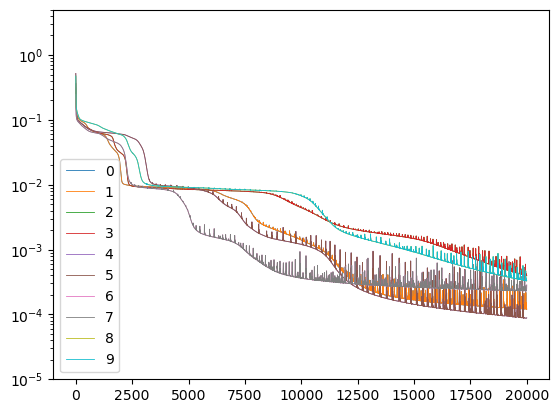

In [ ]:
for i, model in enumerate(all_models):
    current: neural.NN = model
    torch.save(current.state_dict(), f"data/model_{i}.pt")


for i, stats in enumerate(all_stats):
    torch.save(stats, f"data/stats_{i}.pt")

In [ ]:
print(processed_config.loss_blocks["physics"].x[0, :])
print(processed_config.loss_blocks["physics"].x[1, :])

In [5]:
import pickle
with open("data/freq_test/stats.pk", "wb") as file:
    pickle.dump(all_all_stats, file)

# Mega Benchmarking

Text(0, 0.5, 'Loss')

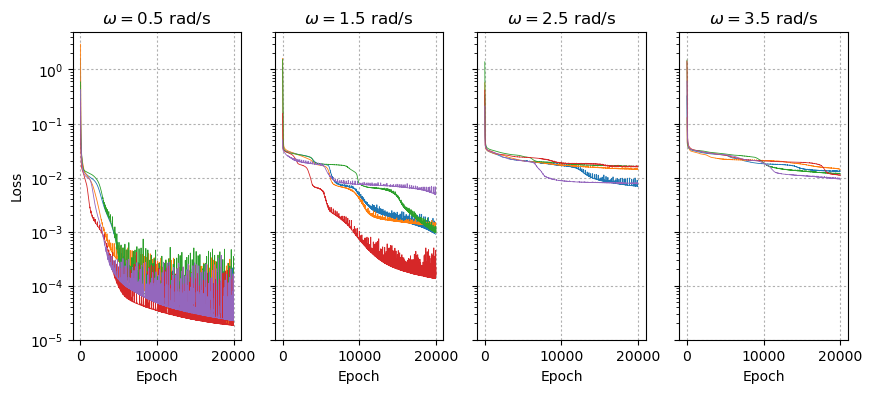

In [17]:
fig = plt.figure(figsize=(10, 4))
axes = fig.subplots(1, len(all_all_stats), sharey=True)

omega_arr

for i in range(len(all_all_stats)):
    for stat in all_all_stats[i]:
        total_loss = stat.total_loss_array
        n_points = len(stat.total_loss_array)
        axes[i].semilogy(
            np.arange(n_points),
            total_loss,
            linewidth=0.6
        )
        axes[i].set_ylim(10**-5, 5*10**-0)

    axes[i].set_title(r"$\omega = " + f"{omega_arr[i]}$" + " rad/s")
    axes[i].grid(dashes=(2, 2), linewidth=0.8)
    axes[i].set_xlabel("Epoch")
    # axes[i].legend(list(range(len(all_stats))), loc="lower left")
axes[0].set_ylabel("Loss")

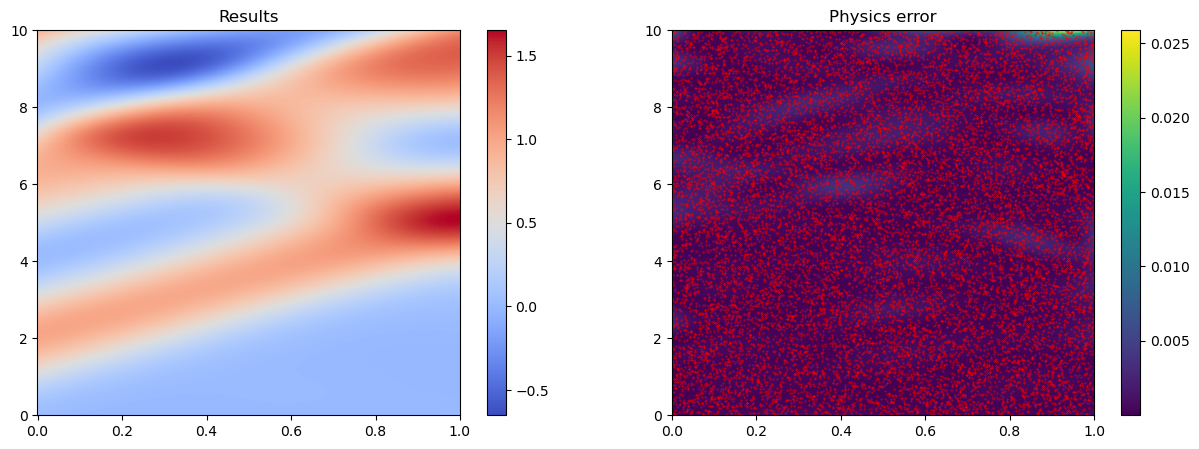

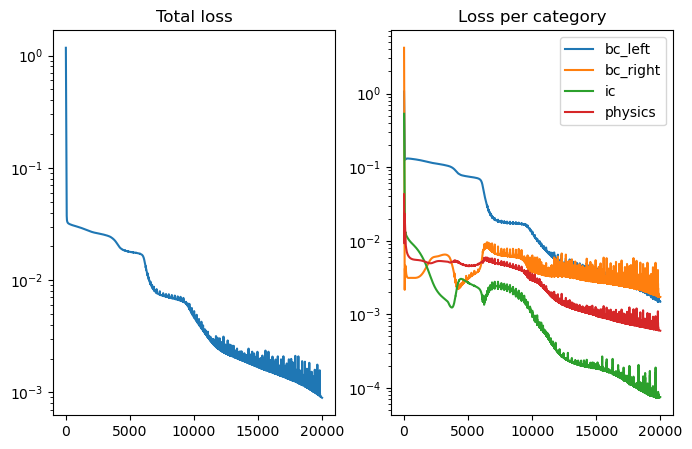

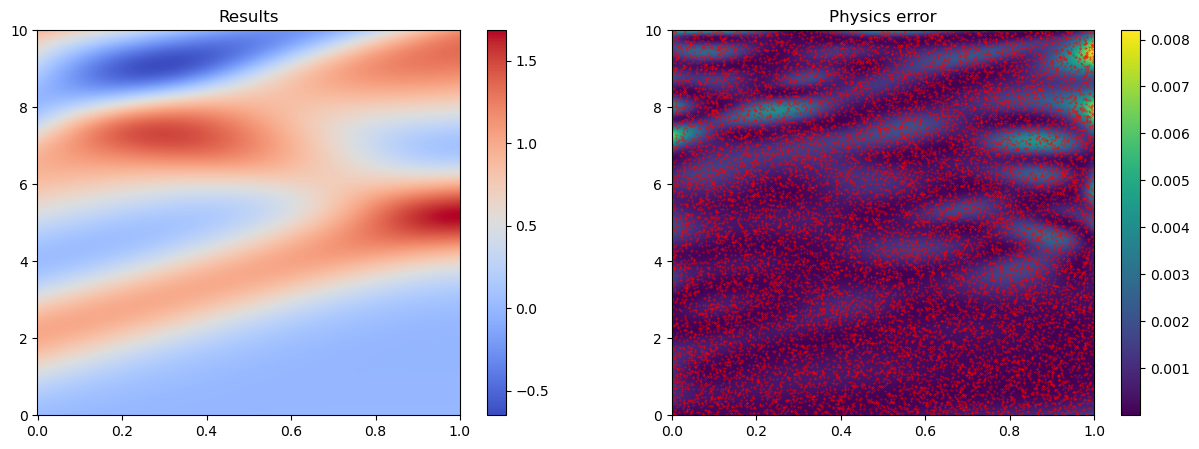

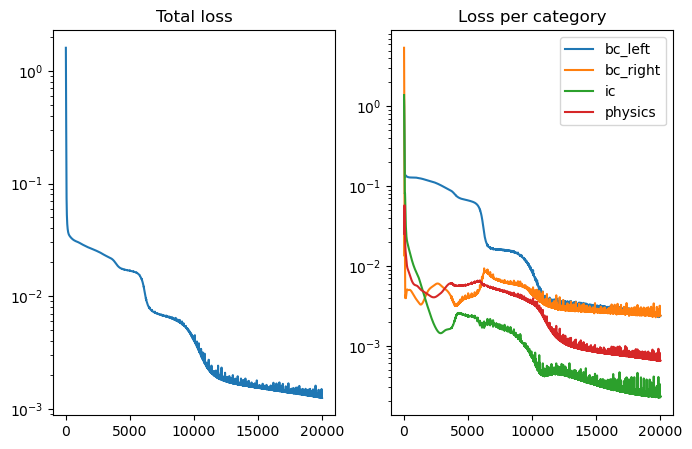

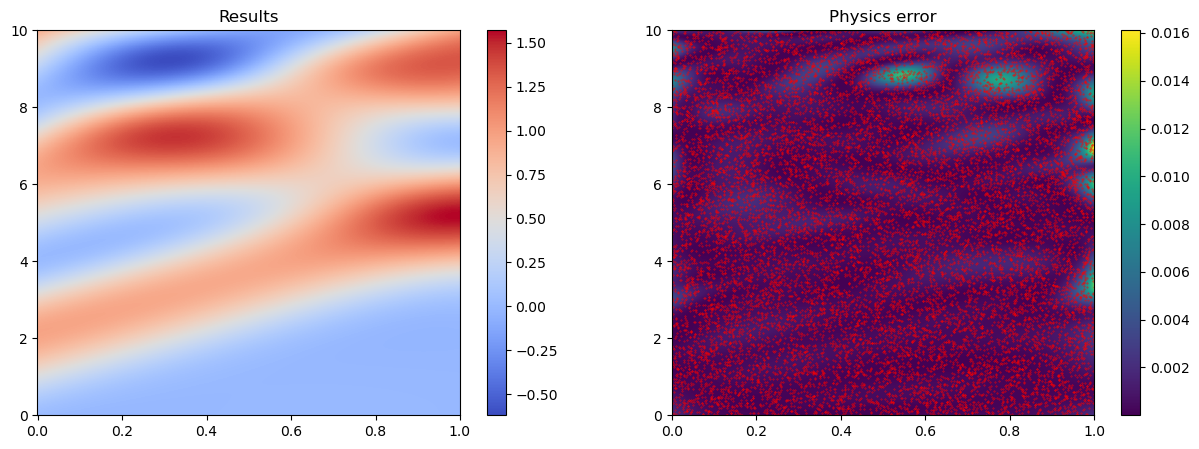

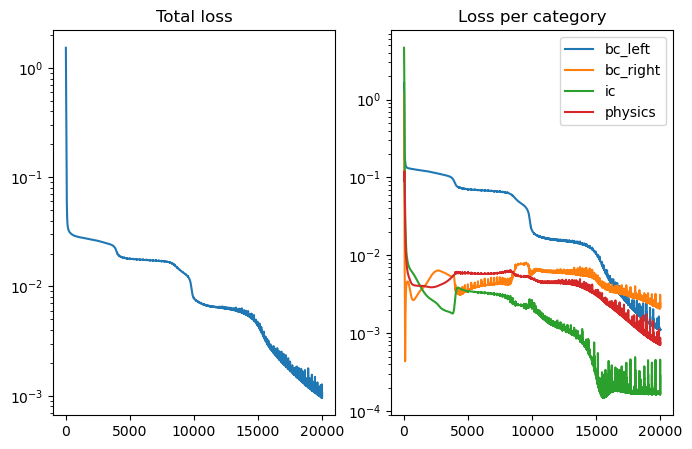

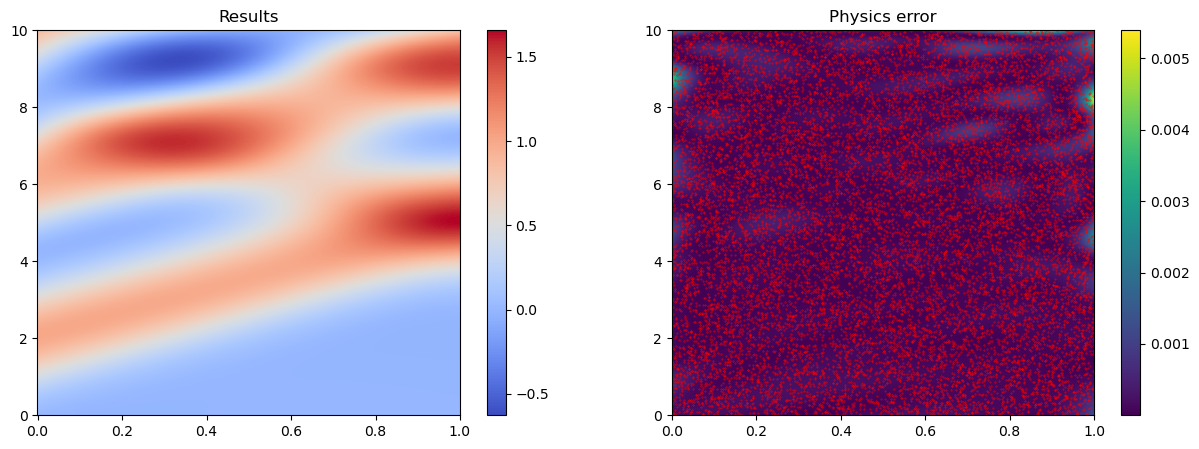

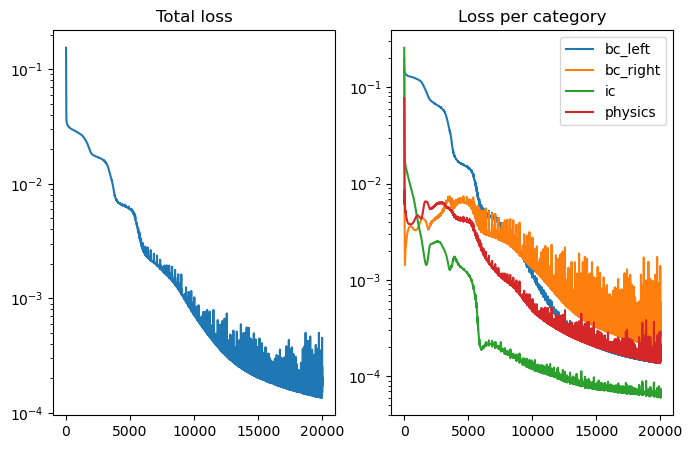

In [27]:
# show_model_results(all_all_models[0][0])
# show_model_results(all_all_models[1][0])
show_model_results(all_all_models[1][0], all_all_stats[1][0])
show_model_results(all_all_models[1][1], all_all_stats[1][1])
show_model_results(all_all_models[1][2], all_all_stats[1][2])
show_model_results(all_all_models[1][3], all_all_stats[1][3])
# show_model_results(all_all_models[3][0])